# Employees Productivity Prediction using Random Forest Classifier
&emsp;This [Dataquest guided project](https://app.dataquest.io/c/140/m/755/guided-project%3A-predicting-employee-productivity-using-tree-models/1/introduction) uses a dataset from [UC Irvine Machine Learning Repository](https://archive.ics.uci.edu/dataset/597/productivity+prediction+of+garment+employees) to practise the application of Random Forest Classifier. Although instructions are given as it is a guided project from Dataquest, approach and methods for reaching the objective, predicting the productivity of employees, could be different.

1. [Dataset/Libraries Initialization](#initial)
2. [Exploratory Data Analysis](#eda)  
&emsp;2.1 [Missing Values](#miss)  
&emsp;2.2 [Numeric Features](#numeric)  
&emsp;&emsp;2.2.1 [Outliers & Misinformation](#outlier)  
&emsp;2.3 [Categorical Features](#categorical)  
3. [Model Training](#train)  
&emsp;3.1 [Preliminary Model](#model1)  
&emsp;3.2 [Random Forest](#forest)  
&emsp;3.3 [Random Forest Classifier](#classifier)

# Dataset/Libraries Initialization<a id='initial'></a>

In [1]:
# array and dataframe
import numpy as np
import pandas as pd
# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use("fivethirtyeight")
%matplotlib inline
import seaborn as sns
# supervised machine learning algorithm and cross validation
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
# metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score

In [2]:
!pip install ucimlrepo
from ucimlrepo import fetch_ucirepo
# fetch dataset
productivity_prediction_of_garment_employees = fetch_ucirepo(id=597)
# data (as pandas dataframes)
X = productivity_prediction_of_garment_employees.data.features
y = productivity_prediction_of_garment_employees.data.targets
Xy = pd.concat([X, y], axis=1)


[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: pip install --upgrade pip


In [3]:
Xy.head(3)

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,1/1/2015,Quarter1,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725
1,1/1/2015,Quarter1,finishing,Thursday,1,0.75,3.94,NaN,960,0,0.0,0,0,8.0,0.886500
2,1/1/2015,Quarter1,sweing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570


## Features
`date` - date of observation  
`quarter` - week of a month (*Quarter5* denotes 29th and onward of a month)  
`department` - department associated of the observation  
`day` - day of the week  
`team` - team number within a department associated of the observation  
`targeted_productivity` - targeted productivity set for the team for that day  
`smv` - standard minute value (the allocated time for the task)  
`wip` - items work in progress  
`over_time` - overtime by minutes  
`incentive` - amount of financial incentive associated with the observation  
`idle_time` - duration of time when the production was interrupted  
`idle_men` - number of employee who were idle during interruption  
`no_of_style_change` - number of changes in style of the product  
`no_of_workers` - number of workers in the team associated with the observation  
`actual_productivity` - percentage of productivity delivered

# Exploratory Data Analysis<a id='eda'></a>

In [4]:
print("Observation:", Xy.shape[0])
print("Feature:", Xy.shape[1])

Observation: 1197
Feature: 15


In [5]:
Xy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   1197 non-null   object 
 1   quarter                1197 non-null   object 
 2   department             1197 non-null   object 
 3   day                    1197 non-null   object 
 4   team                   1197 non-null   int64  
 5   targeted_productivity  1197 non-null   float64
 6   smv                    1197 non-null   float64
 7   wip                    691 non-null    float64
 8   over_time              1197 non-null   int64  
 9   incentive              1197 non-null   int64  
 10  idle_time              1197 non-null   float64
 11  idle_men               1197 non-null   int64  
 12  no_of_style_change     1197 non-null   int64  
 13  no_of_workers          1197 non-null   float64
 14  actual_productivity    1197 non-null   float64
dtypes: f

In [6]:
Xy['date'] = pd.to_datetime(Xy['date'])
Xy.describe(include='all')

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
count,1197,1197,1197,1197,1197.000000,1197.000000,1197.000000,691.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000
unique,NaN,5,2,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Quarter1,sweing,Wednesday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,360,691,208,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2015-02-04 10:56:50.526315776,NaN,NaN,NaN,6.426901,0.729632,15.062172,1190.465991,4567.460317,38.210526,0.730159,0.369256,0.150376,34.609858,0.735091
min,2015-01-01 00:00:00,NaN,NaN,NaN,1.000000,0.070000,2.900000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.233705
25%,2015-01-18 00:00:00,NaN,NaN,NaN,3.000000,0.700000,3.940000,774.500000,1440.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.650307
50%,2015-02-03 00:00:00,NaN,NaN,NaN,6.000000,0.750000,15.260000,1039.000000,3960.000000,0.000000,0.000000,0.000000,0.000000,34.000000,0.773333
75%,2015-02-23 00:00:00,NaN,NaN,NaN,9.000000,0.800000,24.260000,1252.500000,6960.000000,50.000000,0.000000,0.000000,0.000000,57.000000,0.850253
max,2015-03-11 00:00:00,NaN,NaN,NaN,12.000000,0.800000,54.560000,23122.000000,25920.000000,3600.000000,300.000000,45.000000,2.000000,89.000000,1.120437


## Missing Values<a id='miss'></a>

&emsp;There is only a feature, `wip`, having missing values and the number of them is considerably large. Investigation on whether it is missing or it has meaning is needed.

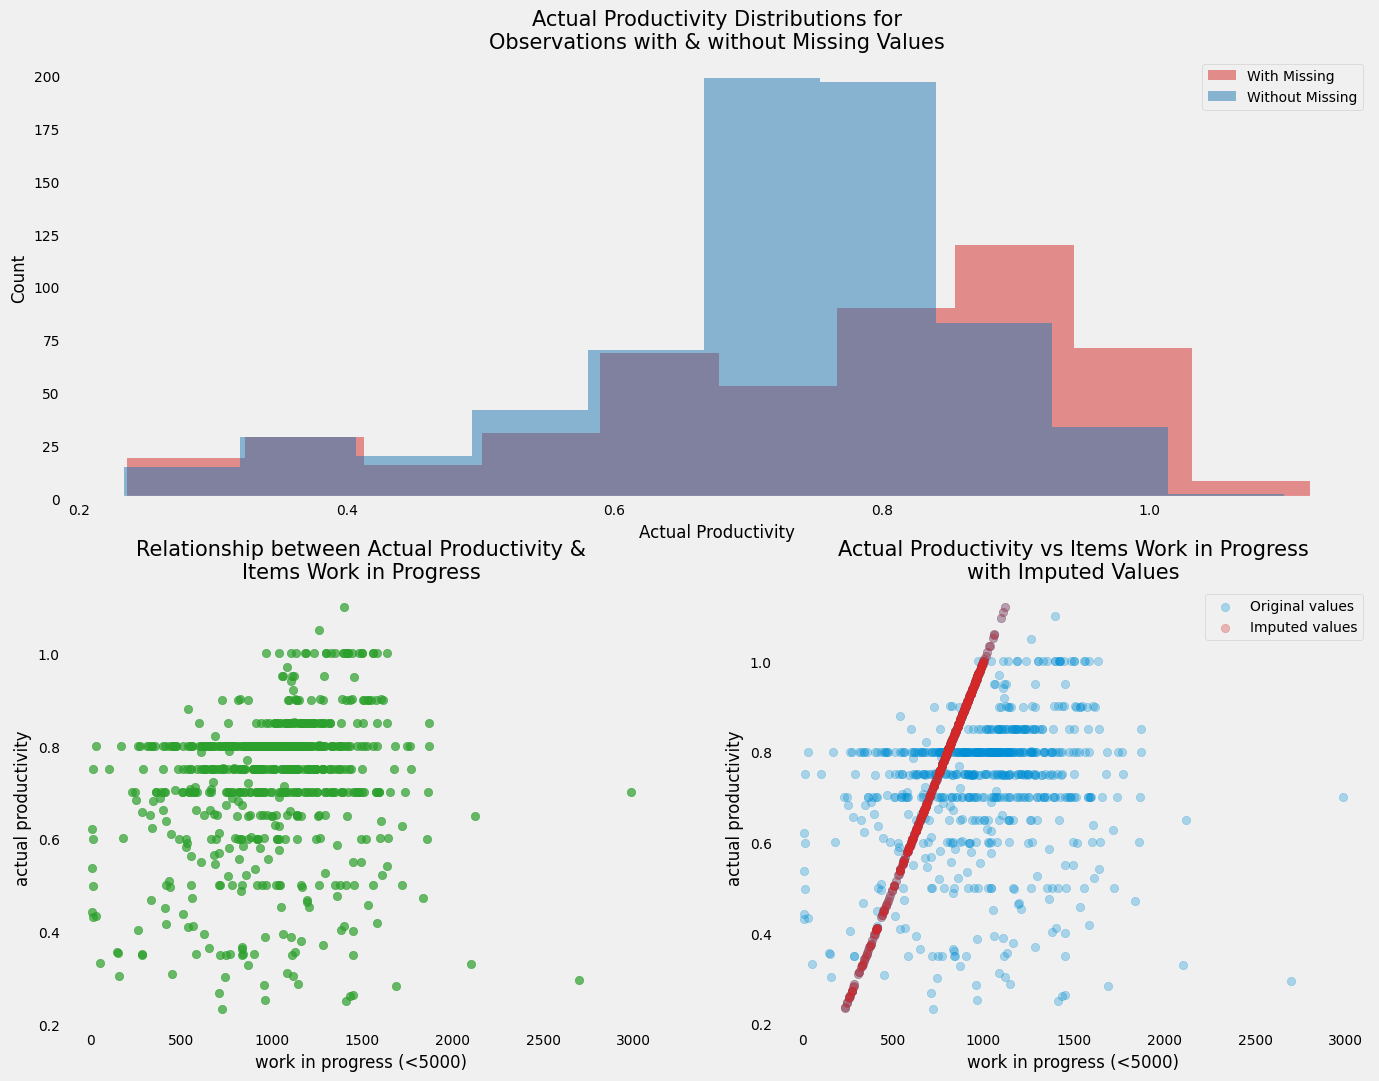

In [7]:
fig = plt.figure(figsize=(15,12))
# Examine values of response variable for the observations with missing values
response_miss = Xy.loc[Xy.isna().sum(axis=1)>0,:]['actual_productivity'] # response for observations with missing values
response_normal = Xy.loc[Xy.isna().sum(axis=1)==0,:]['actual_productivity'] # response for observations with no missing values
fig.add_subplot(2,1,1)
plt.hist(response_miss, alpha=.5, color='tab:red', label='With Missing')
plt.hist(response_normal, alpha=.5, color='tab:blue', label='Without Missing')
plt.legend(fontsize=10)
plt.xlabel("Actual Productivity", fontsize=12)
plt.xticks(fontsize=10)
plt.ylabel("Count", fontsize=12)
plt.yticks(fontsize=10)
plt.grid(False)
plt.title("Actual Productivity Distributions for\nObservations with & without Missing Values", fontsize=15)

# Actual productivity vs work in progress
fig.add_subplot(2,2,3)
plt.scatter('wip', 'actual_productivity', data=Xy[Xy['wip']<5000], color='tab:green', alpha=.7)
plt.xlabel("work in progress (<5000)", fontsize=12)
plt.xticks(fontsize=10)
plt.ylabel("actual productivity", fontsize=12)
plt.yticks(fontsize=10)
plt.grid(False)
plt.title("Relationship between Actual Productivity &\nItems Work in Progress", fontsize=15)

# Show imputed values
index_miss = Xy.loc[Xy.isna().sum(axis=1)>0,:].index
Xy.loc[Xy.isna().sum(axis=1)>0,'wip'] = Xy['actual_productivity'] * 1000 # manual imputation for missing values
fig.add_subplot(2,2,4)
plt.scatter('wip', 'actual_productivity', data=Xy[Xy['wip']<5000], alpha=.3, label="Original values")
plt.scatter('wip', 'actual_productivity', data=Xy.iloc[index_miss,:], color='tab:red', alpha=.3, label="Imputed values")
plt.xlabel("work in progress (<5000)", fontsize=12)
plt.xticks(fontsize=10)
plt.ylabel("actual productivity", fontsize=12)
plt.yticks(fontsize=10)
plt.grid(False)
plt.legend(loc='upper right', fontsize=10)
plt.title("Actual Productivity vs Items Work in Progress\nwith Imputed Values", fontsize=15)

plt.show()

&emsp;Note that in the scatterplots, a few values of `wip` greater or equal to 5000 are excluded to clearly show the relationship for the majority of the abservations.  

&emsp;In the histogram, the observations with missing values in `wip` have more counts among the top end of `actual_productivity`. Since the number of rows with missing `wip` is accountable, manual imputation based on the visual distribution with data points in green is made to retain the significant amount of information in the dataset. The red data points represent the imputed values for `wip` as shown in the bottom scatterplot.

## Numeric Features<a id='numeric'></a>

In [8]:
# numeric features
nums = ['date', 'targeted_productivity', 'smv', 'wip', 'over_time', 'incentive', 'idle_time', 'idle_men', 'no_of_workers', 'actual_productivity']
# categorical features
cats = ['quarter', 'department', 'day', 'team', 'no_of_style_change']

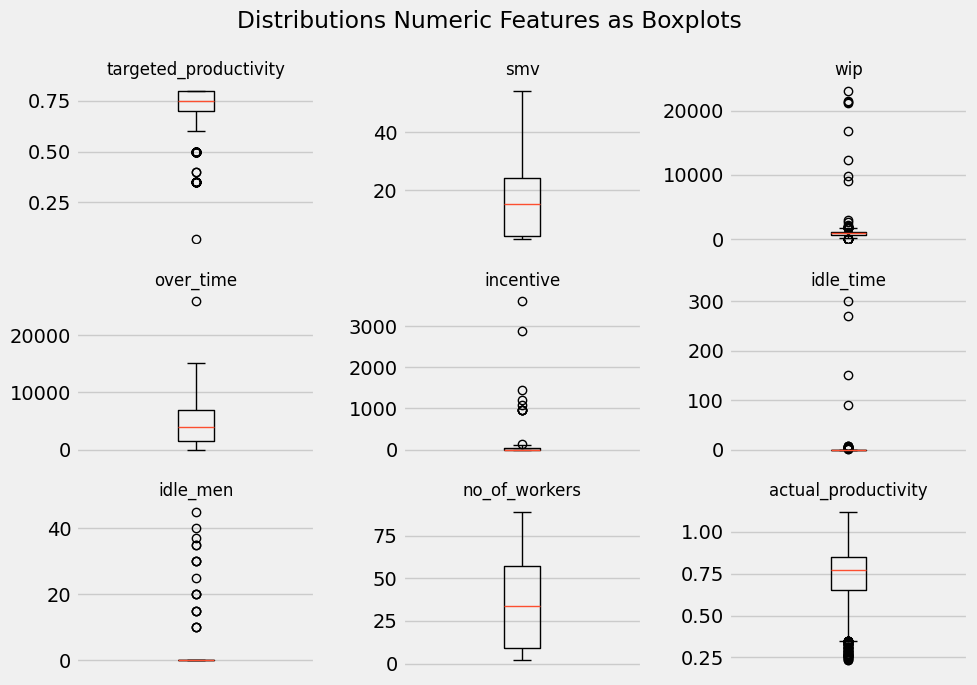

In [9]:
# Relationships between response variable vs numeric features
fig, axes = plt.subplots(3,3, figsize=(10,7))
for i, n in enumerate(nums[1:]):
    ax = axes.ravel()[i]
    ax.boxplot(n, data=Xy, )
    ax.set_xticks([])
    ax.set_title(n, fontsize=12)
fig.suptitle("Distributions Numeric Features as Boxplots")
fig.tight_layout()
plt.show()

&emsp;Many of the numeric features have outliers except for `smv` and `no_of_workers`. They are treated before any further exploration.

### Outliers & Misinformation<a id='outlier'></a>
&emsp;For outliers, I am going to review whether there exists an apparent difference in response variable `actual_productivity` between the outliers and the majority/inliers.

In [10]:
def outlier_exam_numeric(feature):
    '''
    Examination for numeric features with outliers. 
    First, show percentage of outliers.
    Second, display distributions & relationship with response variables.
    
    feature (str): feature in string of the dataset
    
    Return: Indexes of outliers.
    '''
    # Variables for feature column & response column
    feat = Xy[feature]
    resp = Xy['actual_productivity']
    # Calculate outlier boundaries
    iqr = feat.quantile(.75) - feat.quantile(.25)
    lower_out = feat.quantile(.25) - 1.5*iqr
    upper_out = feat.quantile(.75) + 1.5*iqr
    # Display number of outliers & its portion
    outlier_indexes = feat[(feat < lower_out) | (feat > upper_out)].index
    no_outliers = feat[(feat < lower_out) | (feat > upper_out)].shape[0]
    no_total = Xy.shape[0]
    print("Number of outliers:", no_outliers, "out of:", no_total, f"({round(no_outliers/no_total,2)}%)")
    
    # Visualize    
    fig, axes = plt.subplots(1,2, figsize=(16,6))

    axes[0].hist(Xy.loc[~((Xy[feature]<lower_out) | (Xy[feature]>upper_out)), 'actual_productivity'], color='tab:blue', alpha=.5, label='inliers')
    axes[0].hist(Xy.loc[(Xy[feature]<lower_out) | (Xy[feature]>upper_out), 'actual_productivity'], color='tab:red', alpha=.5, label='outliers')
    axes[0].legend(fontsize=12)
    axes[0].tick_params(axis='both', labelsize=10)
    axes[0].set_ylabel('count', fontsize=10)
    axes[0].set_xlabel('actual_productivity', fontsize=10)
    axes[0].set_title('Distributions of Response Variable Values\nof inliers & outliers', fontsize=12)

    axes[1].scatter(feature, 'actual_productivity', data=Xy.loc[~((Xy[feature]<lower_out) | (Xy[feature]>upper_out)), [feature,'actual_productivity']], color='tab:blue', alpha=.5, label='inliers')
    axes[1].scatter(feature, 'actual_productivity', data=Xy.loc[(Xy[feature]<lower_out) | (Xy[feature]>upper_out), [feature,'actual_productivity']], color='tab:red', alpha=.5, label='outliers')
    axes[1].legend(fontsize=12)
    axes[1].tick_params(axis='both', labelsize=10)
    axes[1].set_ylabel('actual_productivity', fontsize=10)
    axes[1].set_xlabel(feature, fontsize=10)
    axes[1].set_title(f'Relationship between Response Variable & {feature}', fontsize=12)

    plt.show()
    
    return outlier_indexes

#### `targeted_productivity`

Number of outliers: 79 out of: 1197 (0.07%)


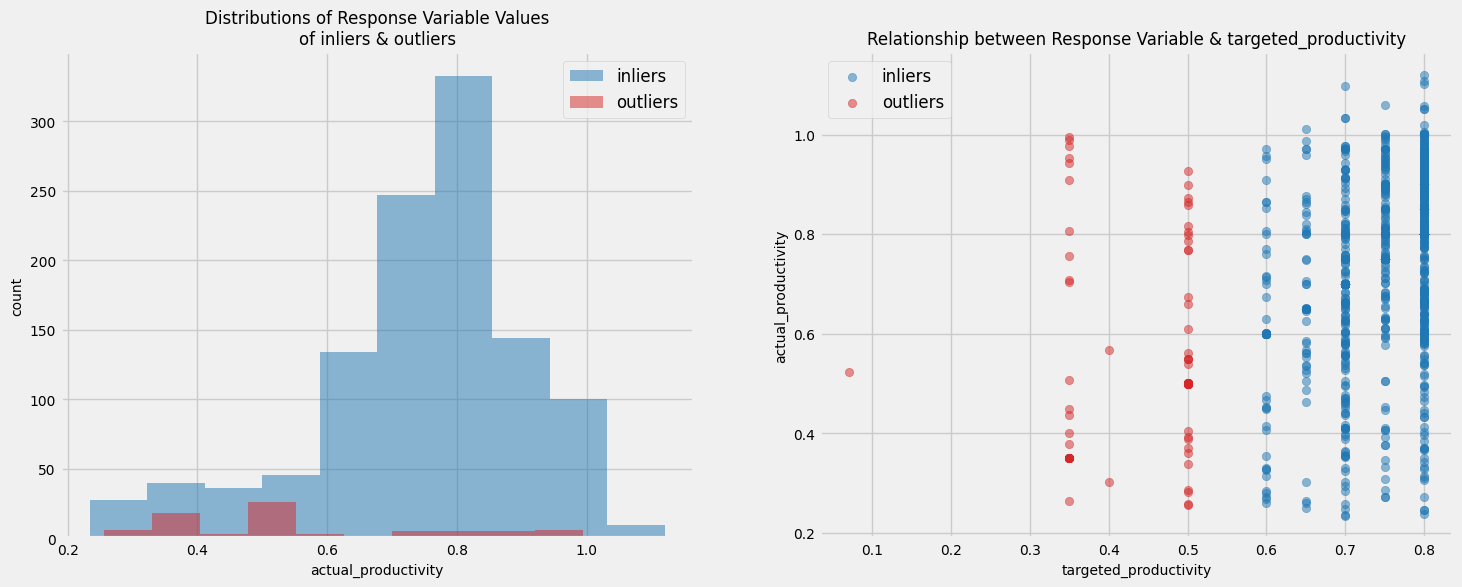

In [11]:
inds = outlier_exam_numeric('targeted_productivity')

&emsp;The `actual_productivity` of the outliers appear to distribute randomly. As a result, they are replaced by values around the mean of the feature `targeted_productivity` itself.

Number of outliers: 0 out of: 1197 (0.0%)


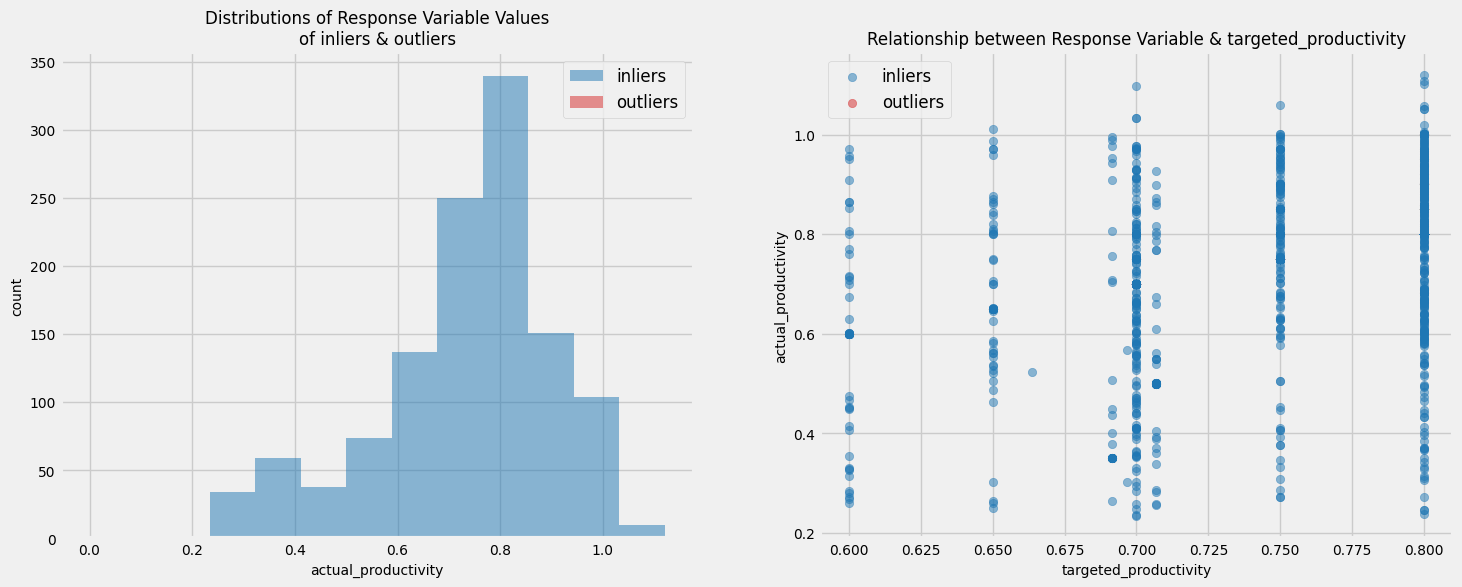

In [12]:
feat_mean = Xy['targeted_productivity'].mean()
Xy.loc[inds,'targeted_productivity'] = Xy['targeted_productivity'].apply(lambda x: feat_mean + (x-feat_mean)/10)
# Re-check outliers
inds = outlier_exam_numeric('targeted_productivity')

#### `wip`

Number of outliers: 33 out of: 1197 (0.03%)


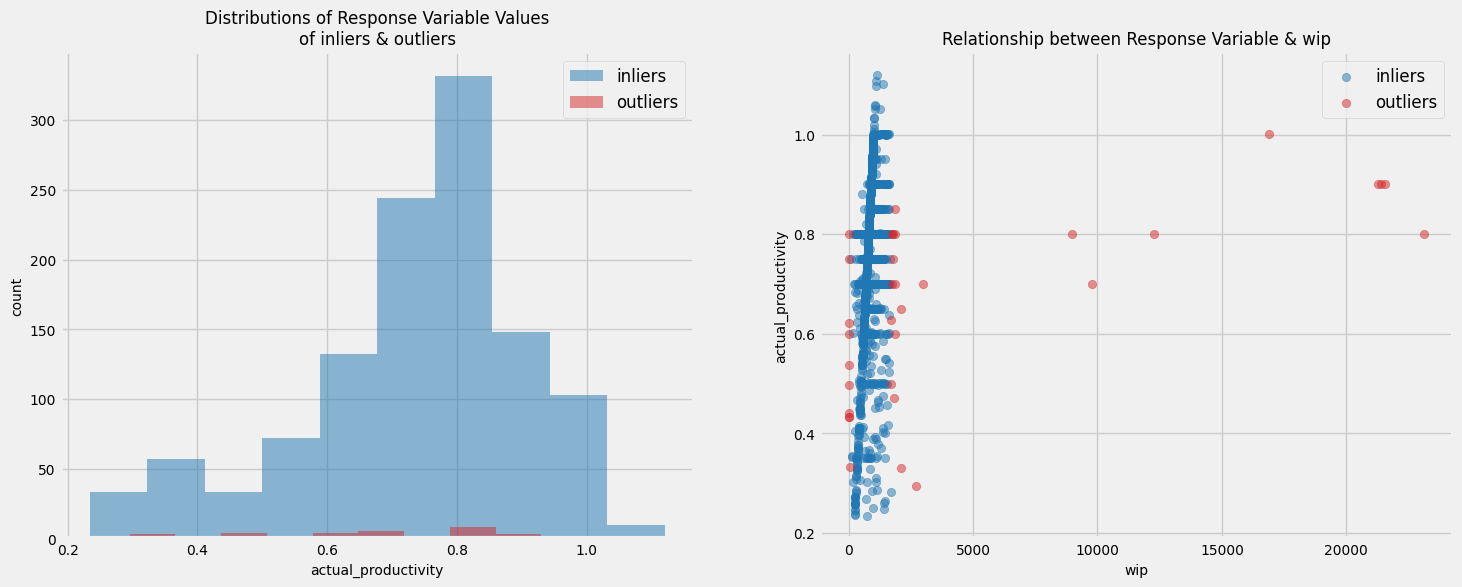

In [13]:
inds = outlier_exam_numeric('wip')

&emsp;The red bars (outliers) appear in a range of `actual_productivity`. The outliers are replaced by values around the mean.

Number of outliers: 12 out of: 1197 (0.01%)


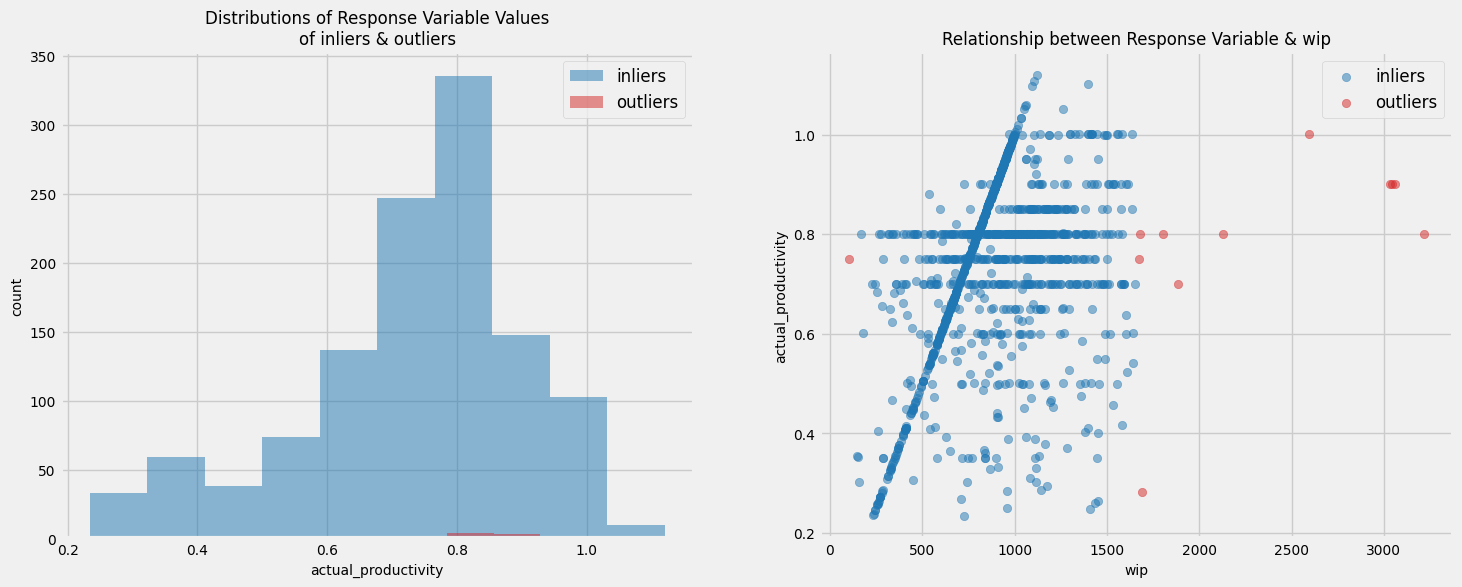

In [14]:
feat_mean = Xy['wip'].mean()
Xy.loc[inds,'wip'] = Xy['wip'].apply(lambda x: feat_mean + (x-feat_mean)/10)
# Re-check outliers
inds = outlier_exam_numeric('wip')

&emsp;After imputation, there are still outliers. They are replaced by median as the red bars only appear near the median.

Number of outliers: 1 out of: 1197 (0.0%)


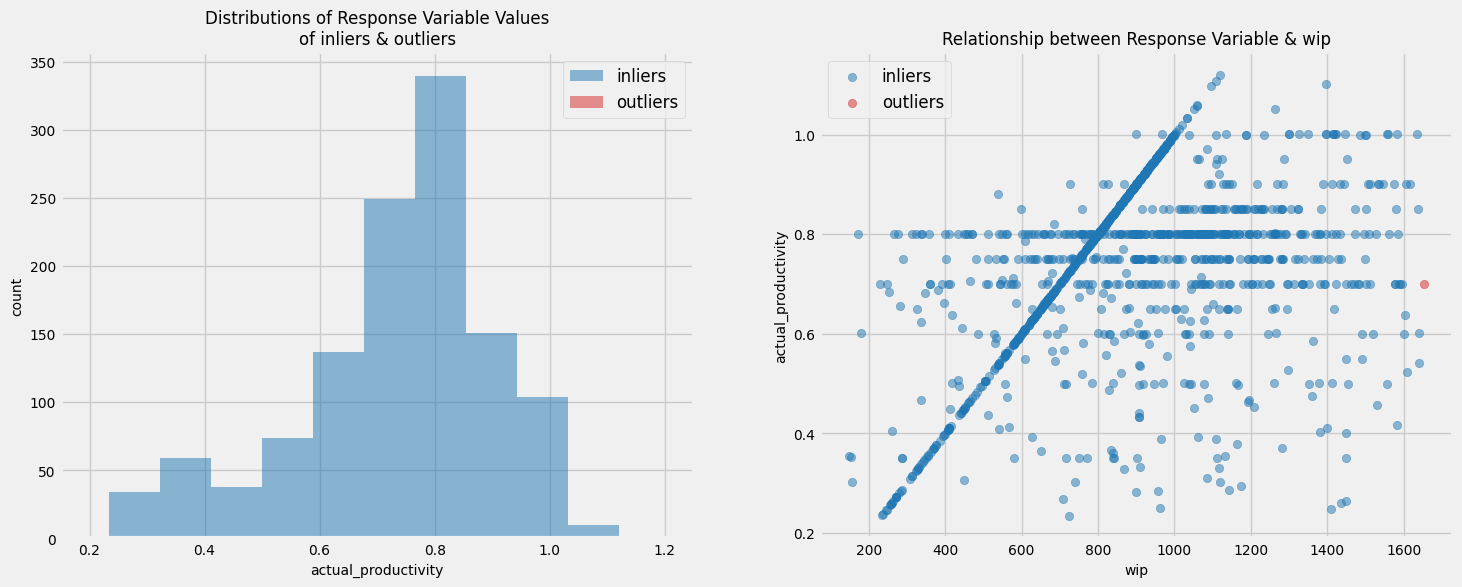

In [15]:
feat_median = Xy['wip'].median()
Xy.loc[inds,'wip'] = feat_median
# Re-check outliers
inds = outlier_exam_numeric('wip')

&emsp;That leaves out 1 outlier.

#### `over_time`

Number of outliers: 1 out of: 1197 (0.0%)


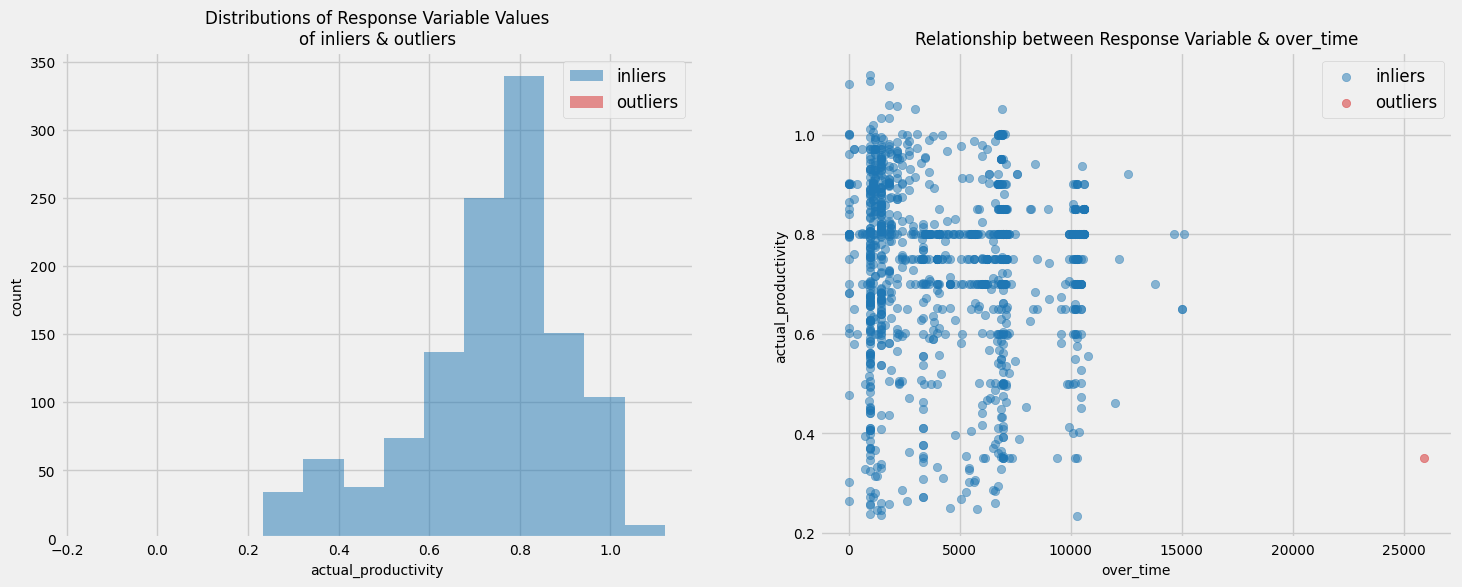

In [16]:
inds = outlier_exam_numeric('over_time')

&emsp;The only outlier is replaced by the second greatest value.

Number of outliers: 0 out of: 1197 (0.0%)


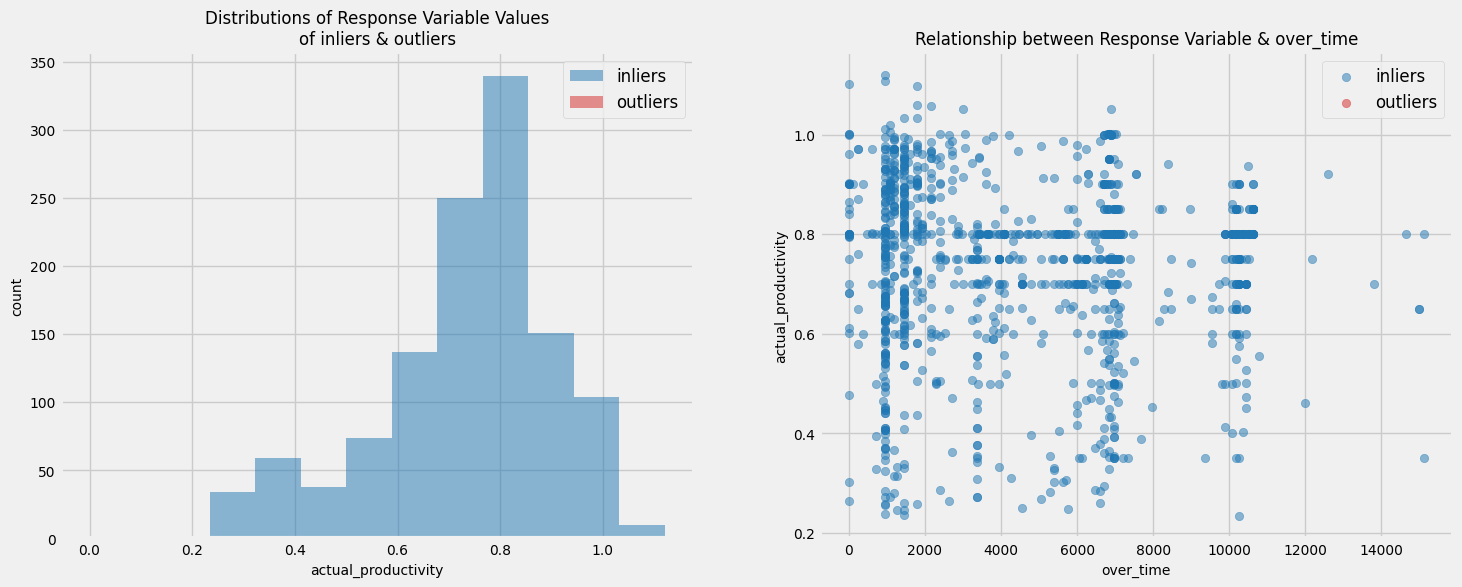

In [17]:
Xy.loc[inds,'over_time'] = sorted(Xy['over_time'], reverse=True)[1]
inds = outlier_exam_numeric('over_time')

#### `incentive`

Number of outliers: 11 out of: 1197 (0.01%)


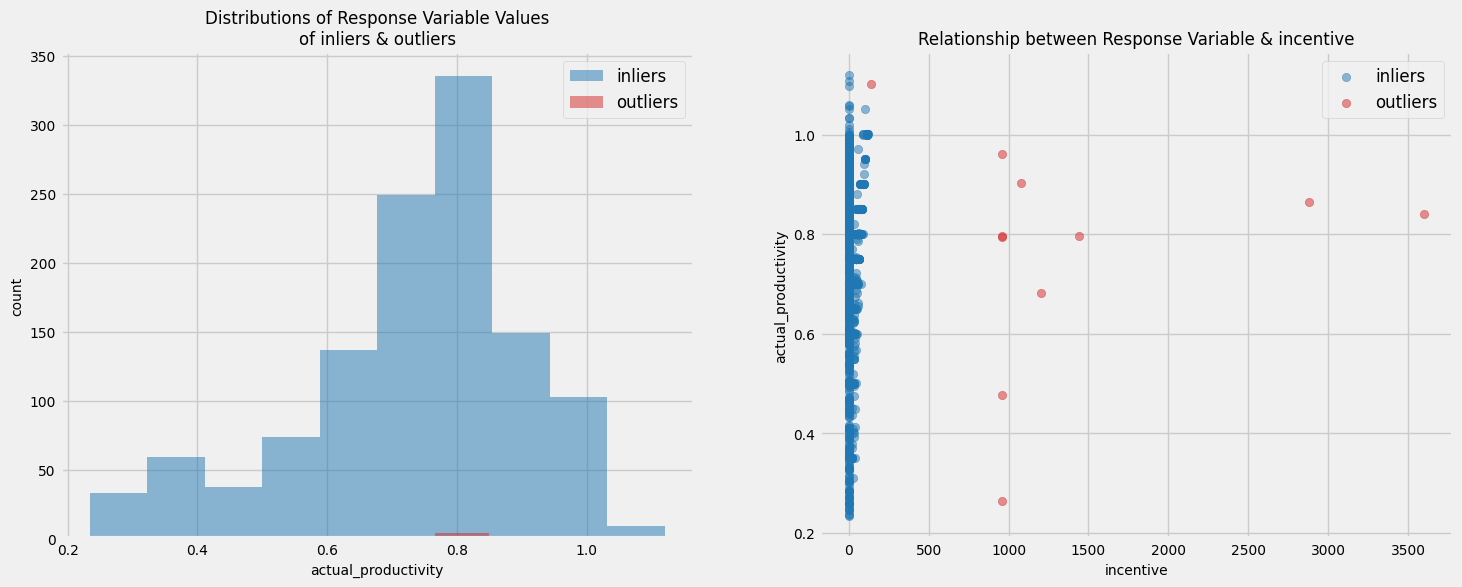

In [18]:
inds = outlier_exam_numeric('incentive')

&emsp;The red bar appears around the median of inliers and the most of red data points are around `actual_productivity` ~ 0.8. Thus the outliers are replaced by the median.

Number of outliers: 0 out of: 1197 (0.0%)


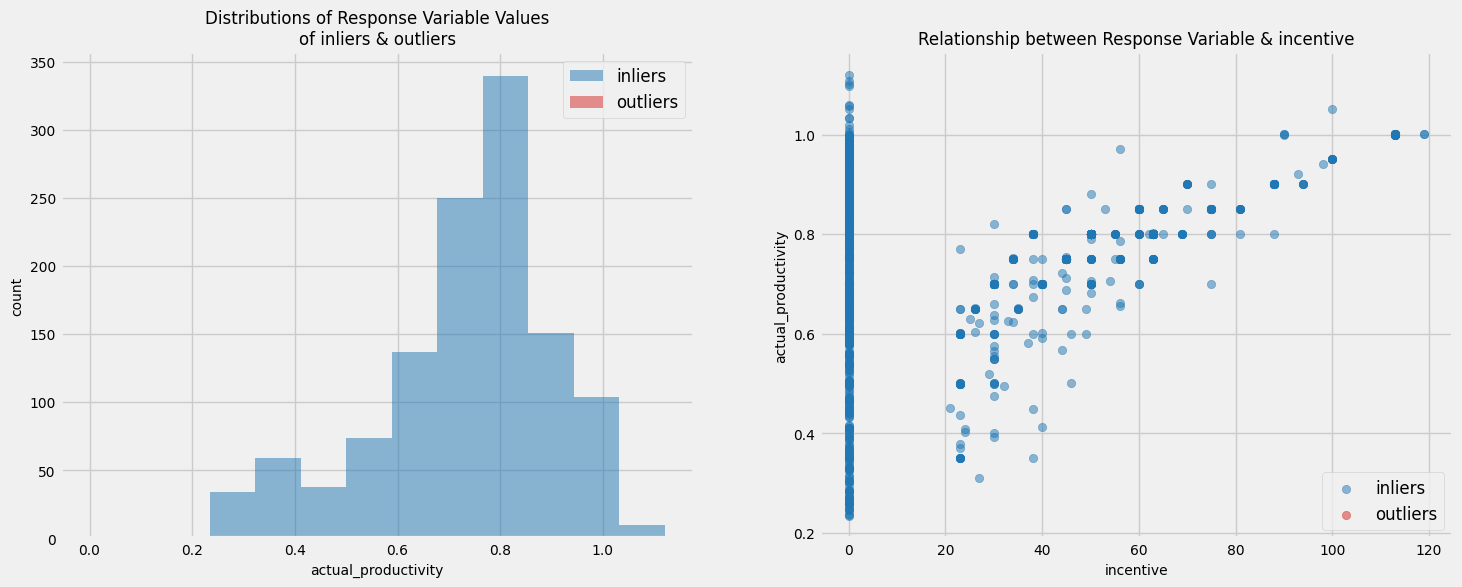

In [19]:
feat_median = Xy['incentive'].median()
Xy.loc[inds,'incentive'] = feat_median
# Re-check outliers
inds = outlier_exam_numeric('incentive')

&emsp;Apparently, the greater the `incentive`, the higher the `actual_productivity`. However, for records with 0 `incentive`, there is not obvious trend or pattern. To increase the effect of this feature, addition of a binary feature, `incentive_yes`, is applied so that records with `incentive` > 0 have `incentive_yes` value as 1; otherwise 0. 

In [20]:
Xy['incentive_yes'] = Xy['incentive'].apply(lambda x: 1 if x > 0 else 0)
Xy.head(2)

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity,incentive_yes
0,2015-01-01,Quarter1,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725,1
1,2015-01-01,Quarter1,finishing,Thursday,1,0.75,3.94,886.5,960,0,0.0,0,0,8.0,0.886500,0


#### `idle_time`

Number of outliers: 18 out of: 1197 (0.02%)


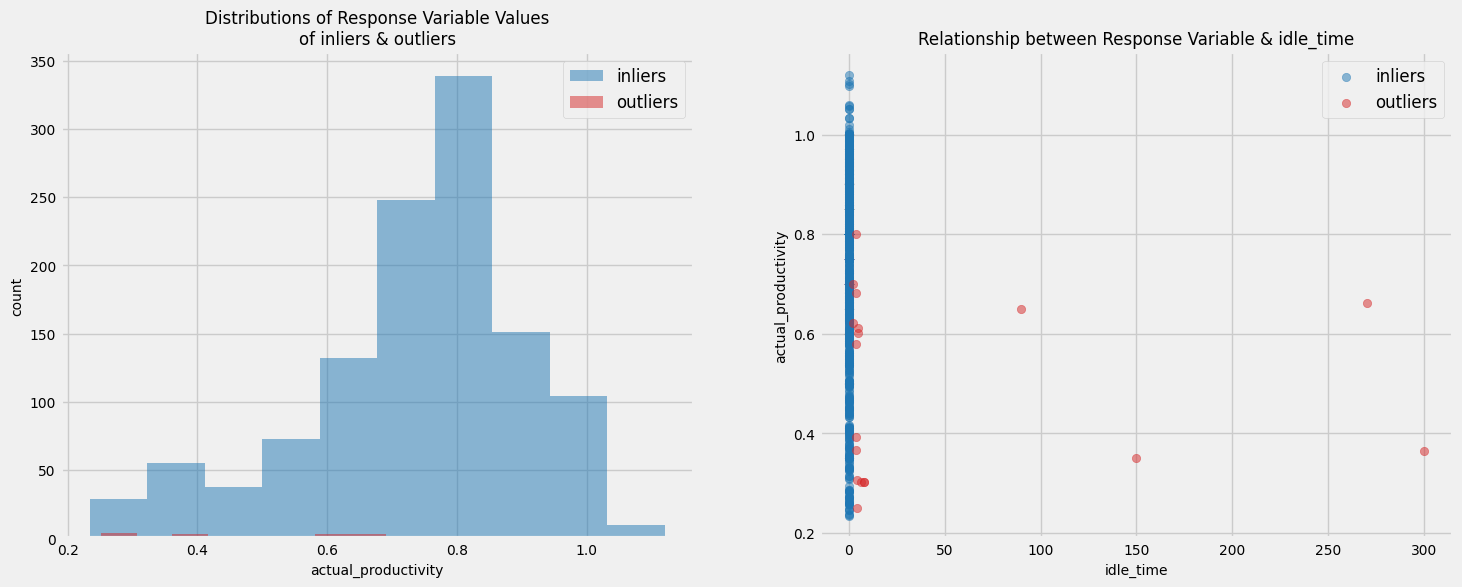

In [21]:
inds = outlier_exam_numeric('idle_time')

&emsp;The number of outliers are actually the records with non-zero `idle_time` values. The values of `actual_productivity` of the outliers are less than or equal to 0.8. So I will make this feature into a binary feature where 0 represents 0 `idle_time` while 1 represents non-zero `idle_time`.

In [22]:
Xy['idle_time_cat'] = Xy['idle_time'].apply(lambda x: 1 if x!=0 else 0)

#### `idle_men`

Number of outliers: 18 out of: 1197 (0.02%)


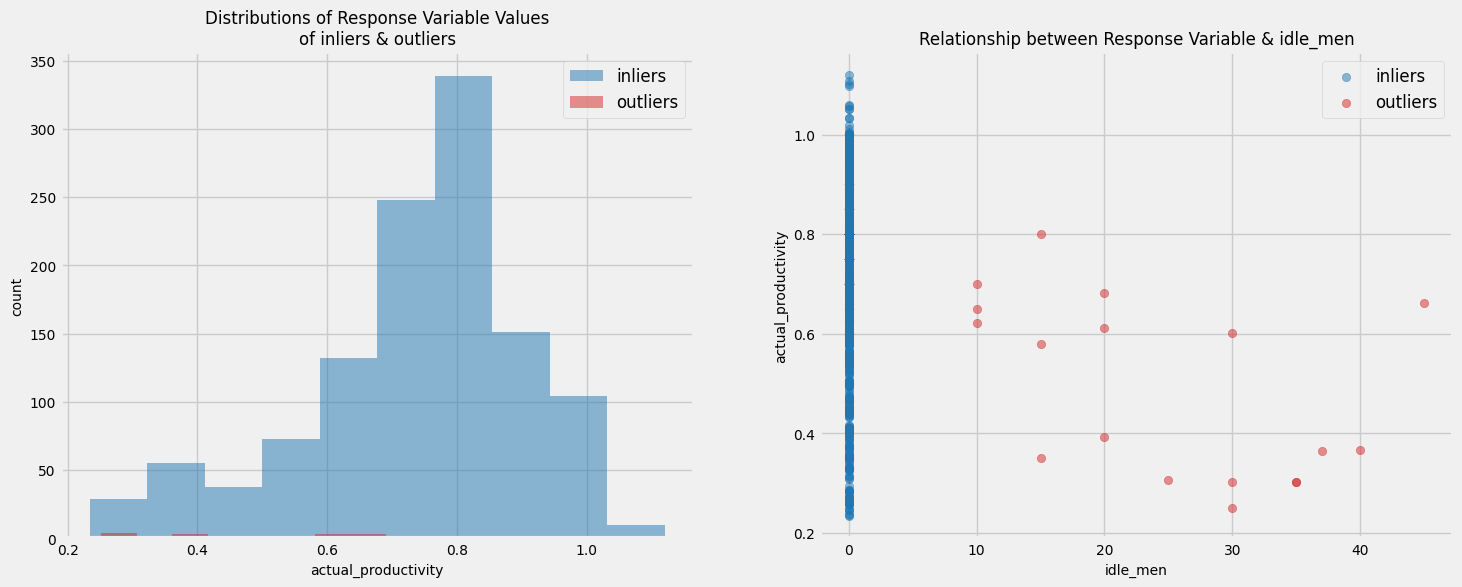

In [23]:
inds = outlier_exam_numeric('idle_men')

&emsp;Similar to `idle_time`, an addition of feature will have values of 0 and 1 for records with `idle_men` equals 0 and non-zero values for `idle_men` respectively.

In [24]:
Xy['idle_men_cat'] = Xy['idle_men'].apply(lambda x: 1 if x!=0 else 0)

#### `actual_productivity` (response variable)
&emsp;The response variable happens to have values over 1. Those values are replaced by 1 which is supposingly the maximum value.

In [25]:
Xy.loc[Xy['actual_productivity']>1, 'actual_productivity'] = 1

In [26]:
# The remaining numeric features for modelling
nums_1 = ['date', 'targeted_productivity', 'smv', 'wip', 'over_time', 'incentive_yes', 'incentive', 'idle_time_cat', 'idle_men_cat', 'no_of_workers', 'actual_productivity']

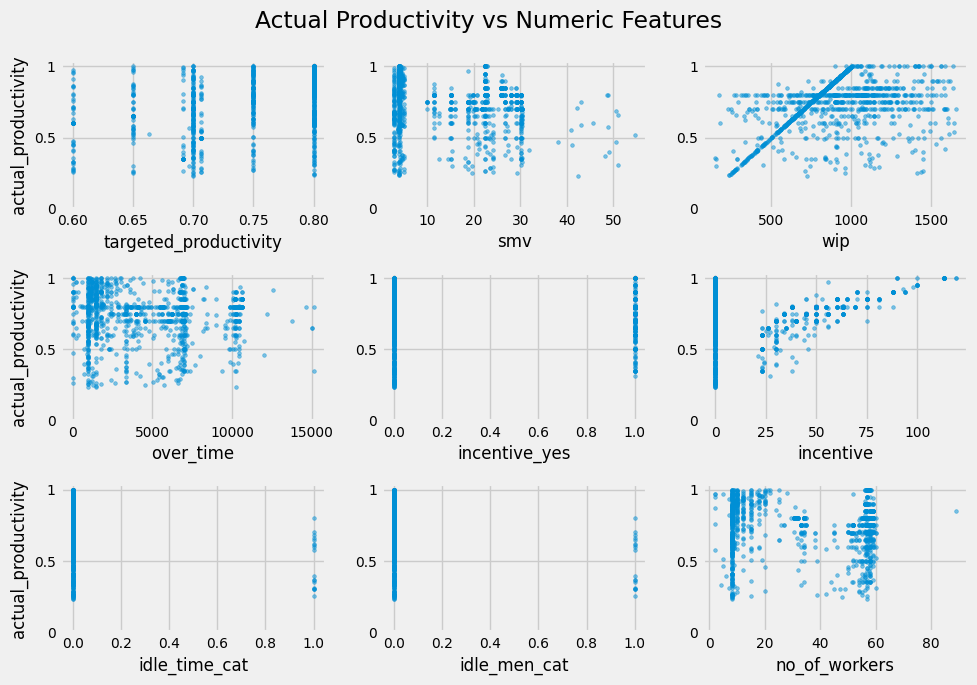

In [27]:
# Relationships between response variable vs numeric features
fig, axes = plt.subplots(3,3, figsize=(10,7))
for i, n in enumerate(nums_1[1:-1]):
    ax = axes.ravel()[i]
    ax.scatter(n, "actual_productivity", data=Xy, alpha=.5, s=7)
    if i%3 == 0:
        ax.set_ylabel("actual_productivity", fontsize=12)
    ax.set_yticks([0, .5, 1], [0, .5, 1], fontsize=10)
    ax.tick_params(axis='x', labelsize=10)
    ax.set_xlabel(n, fontsize=12)
fig.suptitle("Actual Productivity vs Numeric Features")
fig.tight_layout()
plt.show()

## Categorical Features<a id='categorical'></a>

In [28]:
cats.append('actual_productivity')
cats

['quarter',
 'department',
 'day',
 'team',
 'no_of_style_change',
 'actual_productivity']

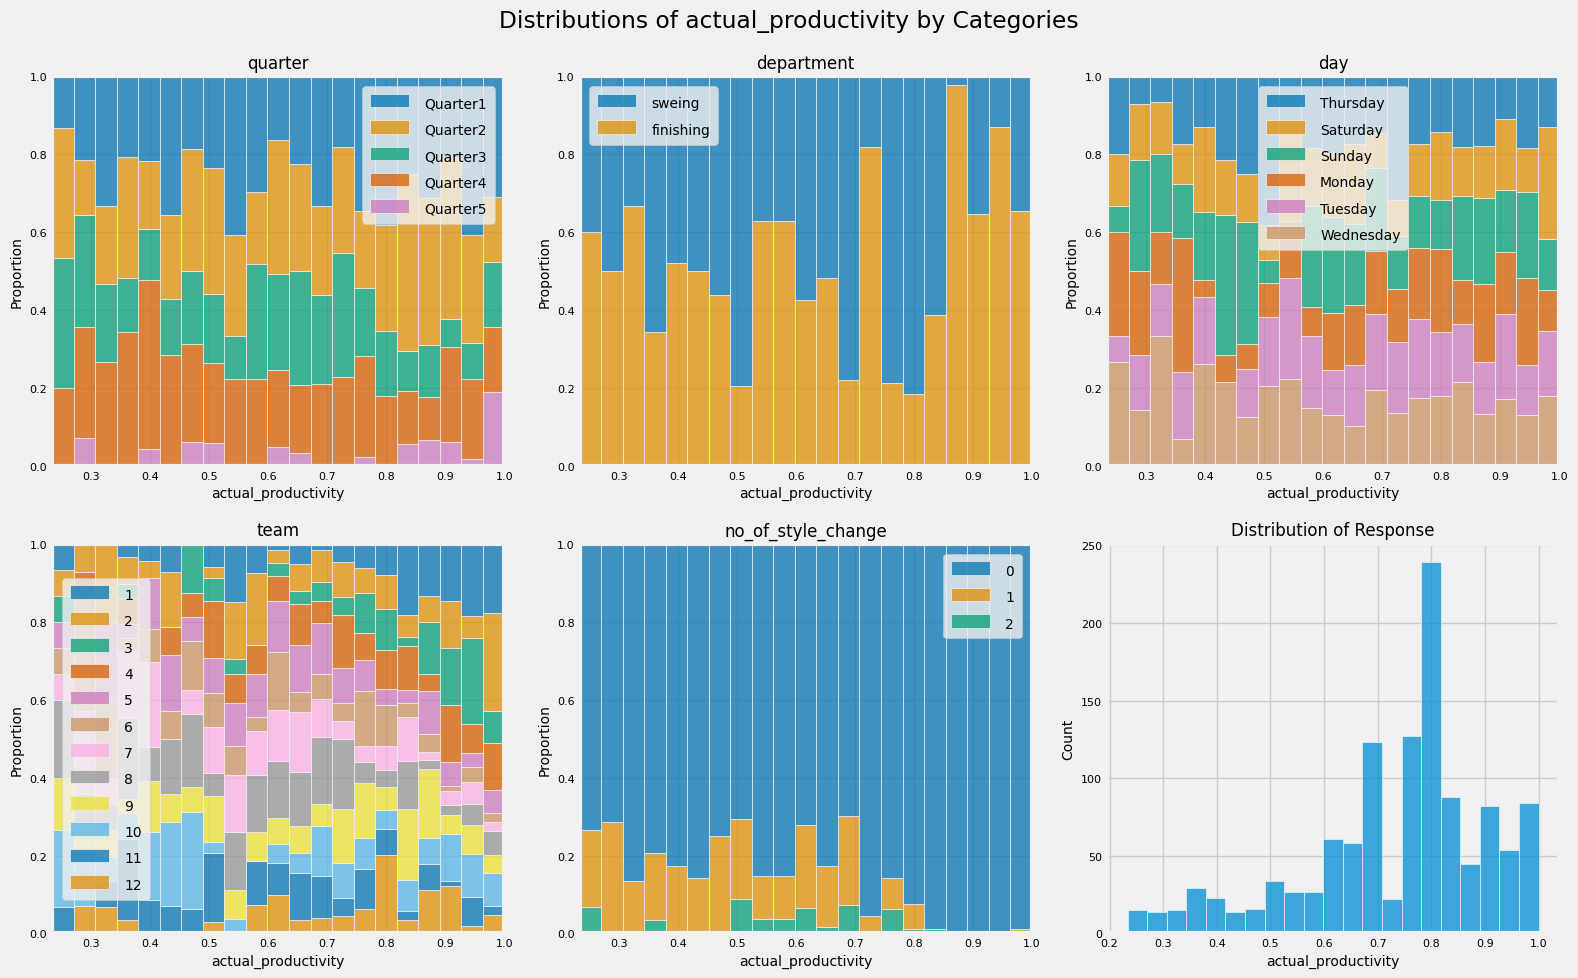

In [29]:
fig, axes = plt.subplots(2,3, figsize=(16,10))
for i in range(6):
    ax = axes.ravel()[i]
    if i != 5:
        hist = sns.histplot(data=Xy[cats], x='actual_productivity', multiple='fill', hue=cats[i], palette='colorblind', ax=ax)
        ax.tick_params(axis='both', labelsize=8)
        ax.set_xlabel('actual_productivity', fontsize=10)
        ax.set_ylabel('Proportion', fontsize=10)
        ax.set_title(cats[i], fontsize=12)
        # Get the legend object
        legend = hist.legend_
        # Change the font size of the legend
        for text in legend.get_texts():
            text.set_fontsize(10)  # Set font size to 14
        legend.set_title(False)
    else:
        hist = sns.histplot(data=Xy[cats], x='actual_productivity', ax=ax)
        ax.tick_params(axis='both', labelsize=8)
        ax.set_xlabel('actual_productivity', fontsize=10)
        ax.set_ylabel('Count', fontsize=10)
        ax.set_title("Distribution of Response", fontsize=12)

fig.suptitle("Distributions of actual_productivity by Categories")
fig.tight_layout()
plt.show()

&emsp;The plots above show the compositions of the response variable `actual_productivity` of by different feature categories. Each bar in the first 5 plots only shows the composition of proportions of each feature category at each range of `actual_productivity`. Only the last plot shows the overall distribution of `actual_productivity`.  

&emsp;Only `no_of_style_change` shows obvious pattern where most records with `actual_productivity` from 0.8 to 1.0 have had no style changes.  

&emsp;Only `no_of_style_change` are considered ordinal. Others are converted into dummy variables.

In [30]:
cats_dummies = pd.get_dummies(Xy[cats[:-2]], columns=cats[:-2], dtype=int)
Xy_dum = pd.concat([Xy, cats_dummies], axis=1)
Xy_dum.drop(columns=['quarter','department','day','team'], inplace=True)
Xy_dum.head(5)

,date,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,...,team_3,team_4,team_5,team_6,team_7,team_8,team_9,team_10,team_11,team_12
0,2015-01-01,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,...,0,0,0,0,0,1,0,0,0,0
1,2015-01-01,0.75,3.94,886.5,960,0,0.0,0,0,8.0,...,0,0,0,0,0,0,0,0,0,0
2,2015-01-01,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,...,0,0,0,0,0,0,0,0,1,0
3,2015-01-01,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,...,0,0,0,0,0,0,0,0,0,1
4,2015-01-01,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,...,0,0,0,1,0,0,0,0,0,0


# Model Training<a id='train'></a>

In [31]:
X = Xy_dum.drop(columns=['date', 'actual_productivity'])
y = Xy_dum['actual_productivity']

In [32]:
# Train/test dataset
X_train, X_val, y_train, y_val =\
    train_test_split(X, y, test_size=.2, random_state=4)
X_train, X_test, y_train, y_test =\
    train_test_split(X_train, y_train, test_size=.2*X.shape[0]/X_train.shape[0], random_state=4)
print(X_train.shape, X_val.shape, X_test.shape)

(717, 37) (240, 37) (240, 37)


## Preliminary Model<a id='model1'></a>

In [33]:
regtree = DecisionTreeRegressor(criterion='squared_error',
                                max_depth=8,
                                min_samples_split=20,
                                min_samples_leaf=5,
                                random_state=4)

In [34]:
regtree.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=8, min_samples_leaf=5, min_samples_split=20,
                      random_state=4)

In [35]:
y_pred_train = regtree.predict(X_train)
y_pred_val = regtree.predict(X_val)

In [36]:
print(mean_squared_error(y_train, y_pred_train), r2_score(y_train, y_pred_train))
print(mean_squared_error(y_val, y_pred_val), r2_score(y_val, y_pred_val))

0.0028921753781479763 0.9022531408358867
0.0073235110005016955 0.7667186807606883


In [37]:
params = {
    'criterion':['squared_error', 'absolute_error', 'poisson'],
    'max_depth':[d for d in range(3,11,2)],
    'min_samples_split':[s for s in range(10,50,5)],
    'min_samples_leaf':[l for l in range(3,10,2)]}
gscv = GridSearchCV(DecisionTreeRegressor(random_state=4),
                    param_grid=params,
                    scoring='r2',
                    cv=10,
                    n_jobs=-1)
gscv.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(random_state=4), n_jobs=-1,
             param_grid={'criterion': ['squared_error', 'absolute_error',
                                       'poisson'],
                         'max_depth': [3, 5, 7, 9],
                         'min_samples_leaf': [3, 5, 7, 9],
                         'min_samples_split': [10, 15, 20, 25, 30, 35, 40, 45]},
             scoring='r2')

In [38]:
gscv.best_score_, gscv.best_params_

(0.8352413731127459,
 {'criterion': 'squared_error',
  'max_depth': 9,
  'min_samples_leaf': 7,
  'min_samples_split': 15})

In [39]:
best_est = gscv.best_estimator_
best_est.fit(X_train, y_train)
y_pred_train = best_est.predict(X_train)
y_pred_val = best_est.predict(X_val)
print(mean_squared_error(y_train, y_pred_train), r2_score(y_train, y_pred_train))
print(mean_squared_error(y_val, y_pred_val), r2_score(y_val, y_pred_val))

0.0027093735809255383 0.9084312936764971
0.006396373584162778 0.7962514881238305


&emsp;As shown, overfitting is quite prominent. Minimum cost complexity pruning is used to address the issue.

In [40]:
cost_tree = DecisionTreeRegressor(random_state = 4)
cost_path = cost_tree.cost_complexity_pruning_path(X_train, y_train)
cost_path.ccp_alphas
subtrees = []
for alpha in cost_path.ccp_alphas:
    subtree = DecisionTreeRegressor(random_state = 4, ccp_alpha = alpha)
    subtree.fit(X_train, y_train)
    subtrees.append(subtree)
ccp_alphas_slice = cost_path.ccp_alphas[:]
subtrees_slice = subtrees[:] # Both slices are required to match.
subtree_scores = [subtree.score(X_test, y_test) for subtree in subtrees_slice]
alpha_scores = tuple(zip(ccp_alphas_slice, subtree_scores))
best_alpha = max(alpha_scores, key=lambda x:x[1])[0]
print(max(alpha_scores, key=lambda x:x[1]))

(5.9384199279076584e-05, 0.8474472457743784)


In [41]:
# Re initialize tree with alpha
regtree_a = DecisionTreeRegressor(random_state=4, ccp_alpha=max(alpha_scores, key=lambda x:x[1])[0])
regtree_a.fit(X_train, y_train)
y_pred_train = regtree_a.predict(X_train)
y_pred_val = regtree_a.predict(X_val)
print(f"MSE: {mean_squared_error(y_train, y_pred_train)}, R^2: {r2_score(y_train, y_pred_train)}")
print(f"MSE: {mean_squared_error(y_val, y_pred_val)}, R^2: {r2_score(y_val, y_pred_val)}")

MSE: 0.0019410302599686014, R^2: 0.9343989949959647
MSE: 0.010116800574393325, R^2: 0.6777419212842273


&emsp;After pruning, the overfitting problem is worse. Random Forest is used to address the problem instead.

## Random Forest<a id='forest'></a>

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=4)

forest = RandomForestRegressor(random_state=4, n_jobs=-1, warm_start=True)
params = {
    "n_estimators":[100, 200, 300],
    "max_features":[.3, .6, .9],
    "max_depth":[None, 10, 20],
    "min_samples_leaf":[1, 2, 5],
    "bootstrap":[True, False]
}
gscv = GridSearchCV(forest,
                    param_grid=params,
                    n_jobs=-1,
                    cv=10,
                    verbose=1)
gscv.fit(X_train, y_train)

Fitting 10 folds for each of 162 candidates, totalling 1620 fits


GridSearchCV(cv=10,
             estimator=RandomForestRegressor(n_jobs=-1, random_state=4,
                                             warm_start=True),
             n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 10, 20],
                         'max_features': [0.3, 0.6, 0.9],
                         'min_samples_leaf': [1, 2, 5],
                         'n_estimators': [100, 200, 300]},
             verbose=1)

In [43]:
forest = gscv.best_estimator_
gscv.best_score_

0.8944348773863323

In [44]:
y_pred_test = forest.predict(X_test)
r2_score(y_test, y_pred_test)

0.8593322757264135

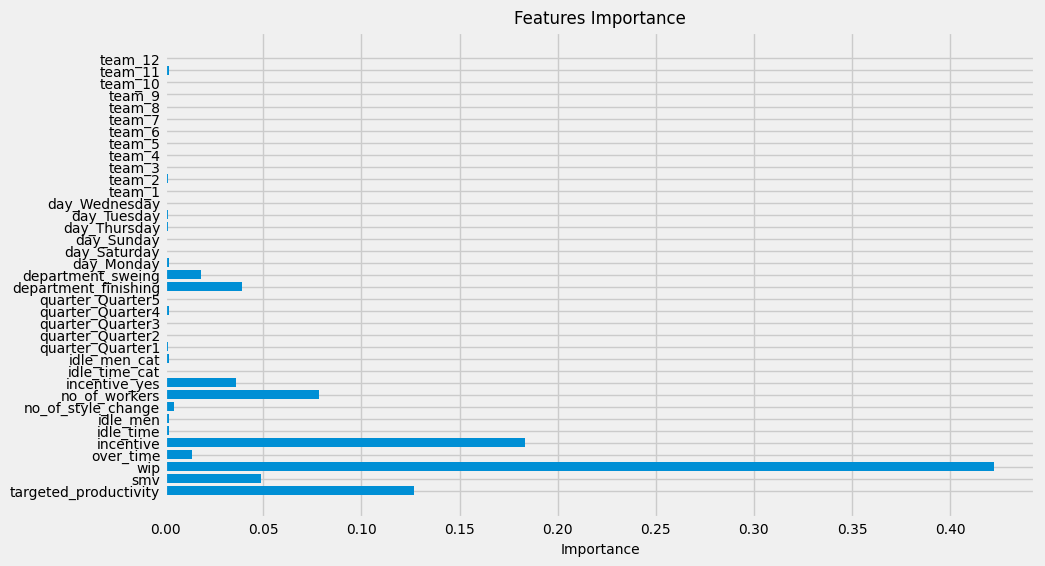

In [45]:
plt.figure(figsize=(10,6))
plt.barh(forest.feature_names_in_, forest.feature_importances_)
plt.title("Features Importance", fontsize=12)
plt.xlabel("Importance", fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

&emsp;The bar plot shows the importance of each feature to the model. Less than half of the features have prominent importance. Retraining model with features with prominent importance to see if overfitting can be further reduced.

In [46]:
feature_importances = pd.DataFrame(data=zip(forest.feature_names_in_, forest.feature_importances_), columns=['feature', 'importance'])
feature_importances_sorted = feature_importances.sort_values(by='importance', axis=0, ascending=False)
top_feat = feature_importances_sorted[feature_importances_sorted['importance'] > .01]['feature']

In [47]:
gscv.fit(X_train[top_feat], y_train)

Fitting 10 folds for each of 162 candidates, totalling 1620 fits


GridSearchCV(cv=10,
             estimator=RandomForestRegressor(n_jobs=-1, random_state=4,
                                             warm_start=True),
             n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 10, 20],
                         'max_features': [0.3, 0.6, 0.9],
                         'min_samples_leaf': [1, 2, 5],
                         'n_estimators': [100, 200, 300]},
             verbose=1)

In [48]:
forest2 = gscv.best_estimator_
gscv.best_score_

0.8941532072906477

In [49]:
y_pred_test = forest2.predict(X_test[top_feat])
r2_score(y_test, y_pred_test)

0.8633513442206286

&emsp;That gap narrows down slightly.

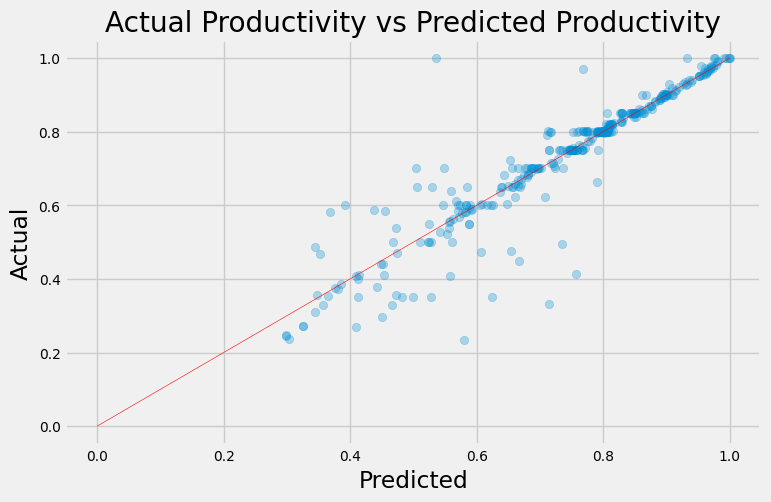

In [50]:
plt.figure(figsize=(8,5))
plt.scatter(y_pred_test, y_test, alpha=.3)
plt.plot([0,1],[0,1], lw=.4, c='red')
plt.tick_params(axis='both', labelsize=10)
plt.title("Actual Productivity vs Predicted Productivity")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

&emsp;The performance of the model varies with `productivity` value. From the visual, the model performs well for value above 0.8. Below that, the discrepancy enlarges significantly. The model seems to work great in identifying great `productivity` (≥ 0.8). There are only a few predictions having large gap from the actual value.  

&emsp;In the following, a classifier is built instead of a regressor to identify the excellent `productivity` (≥ 80%) using the same features.

## Classifier<a id='classifier'></a>

In [51]:
y_train = y_train.apply(lambda x: "Excellent" if x >= .8 else "Normal")
y_test = y_test.apply(lambda x: "Excellent" if x >= .8 else "Normal")

In [52]:
params = {
    "criterion":["gini", "entropy"],
    "max_depth":[5, 10, 20],
    "min_samples_leaf":[1, 2, 5],
    "max_features":[.3, .6, .9],
}
clf = DecisionTreeClassifier(random_state=4)

gscv_clf = GridSearchCV(clf,
                        param_grid=params,
                        n_jobs=-1,
                        cv=10)
gscv_clf.fit(X_train[top_feat], y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=4), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 20],
                         'max_features': [0.3, 0.6, 0.9],
                         'min_samples_leaf': [1, 2, 5]})

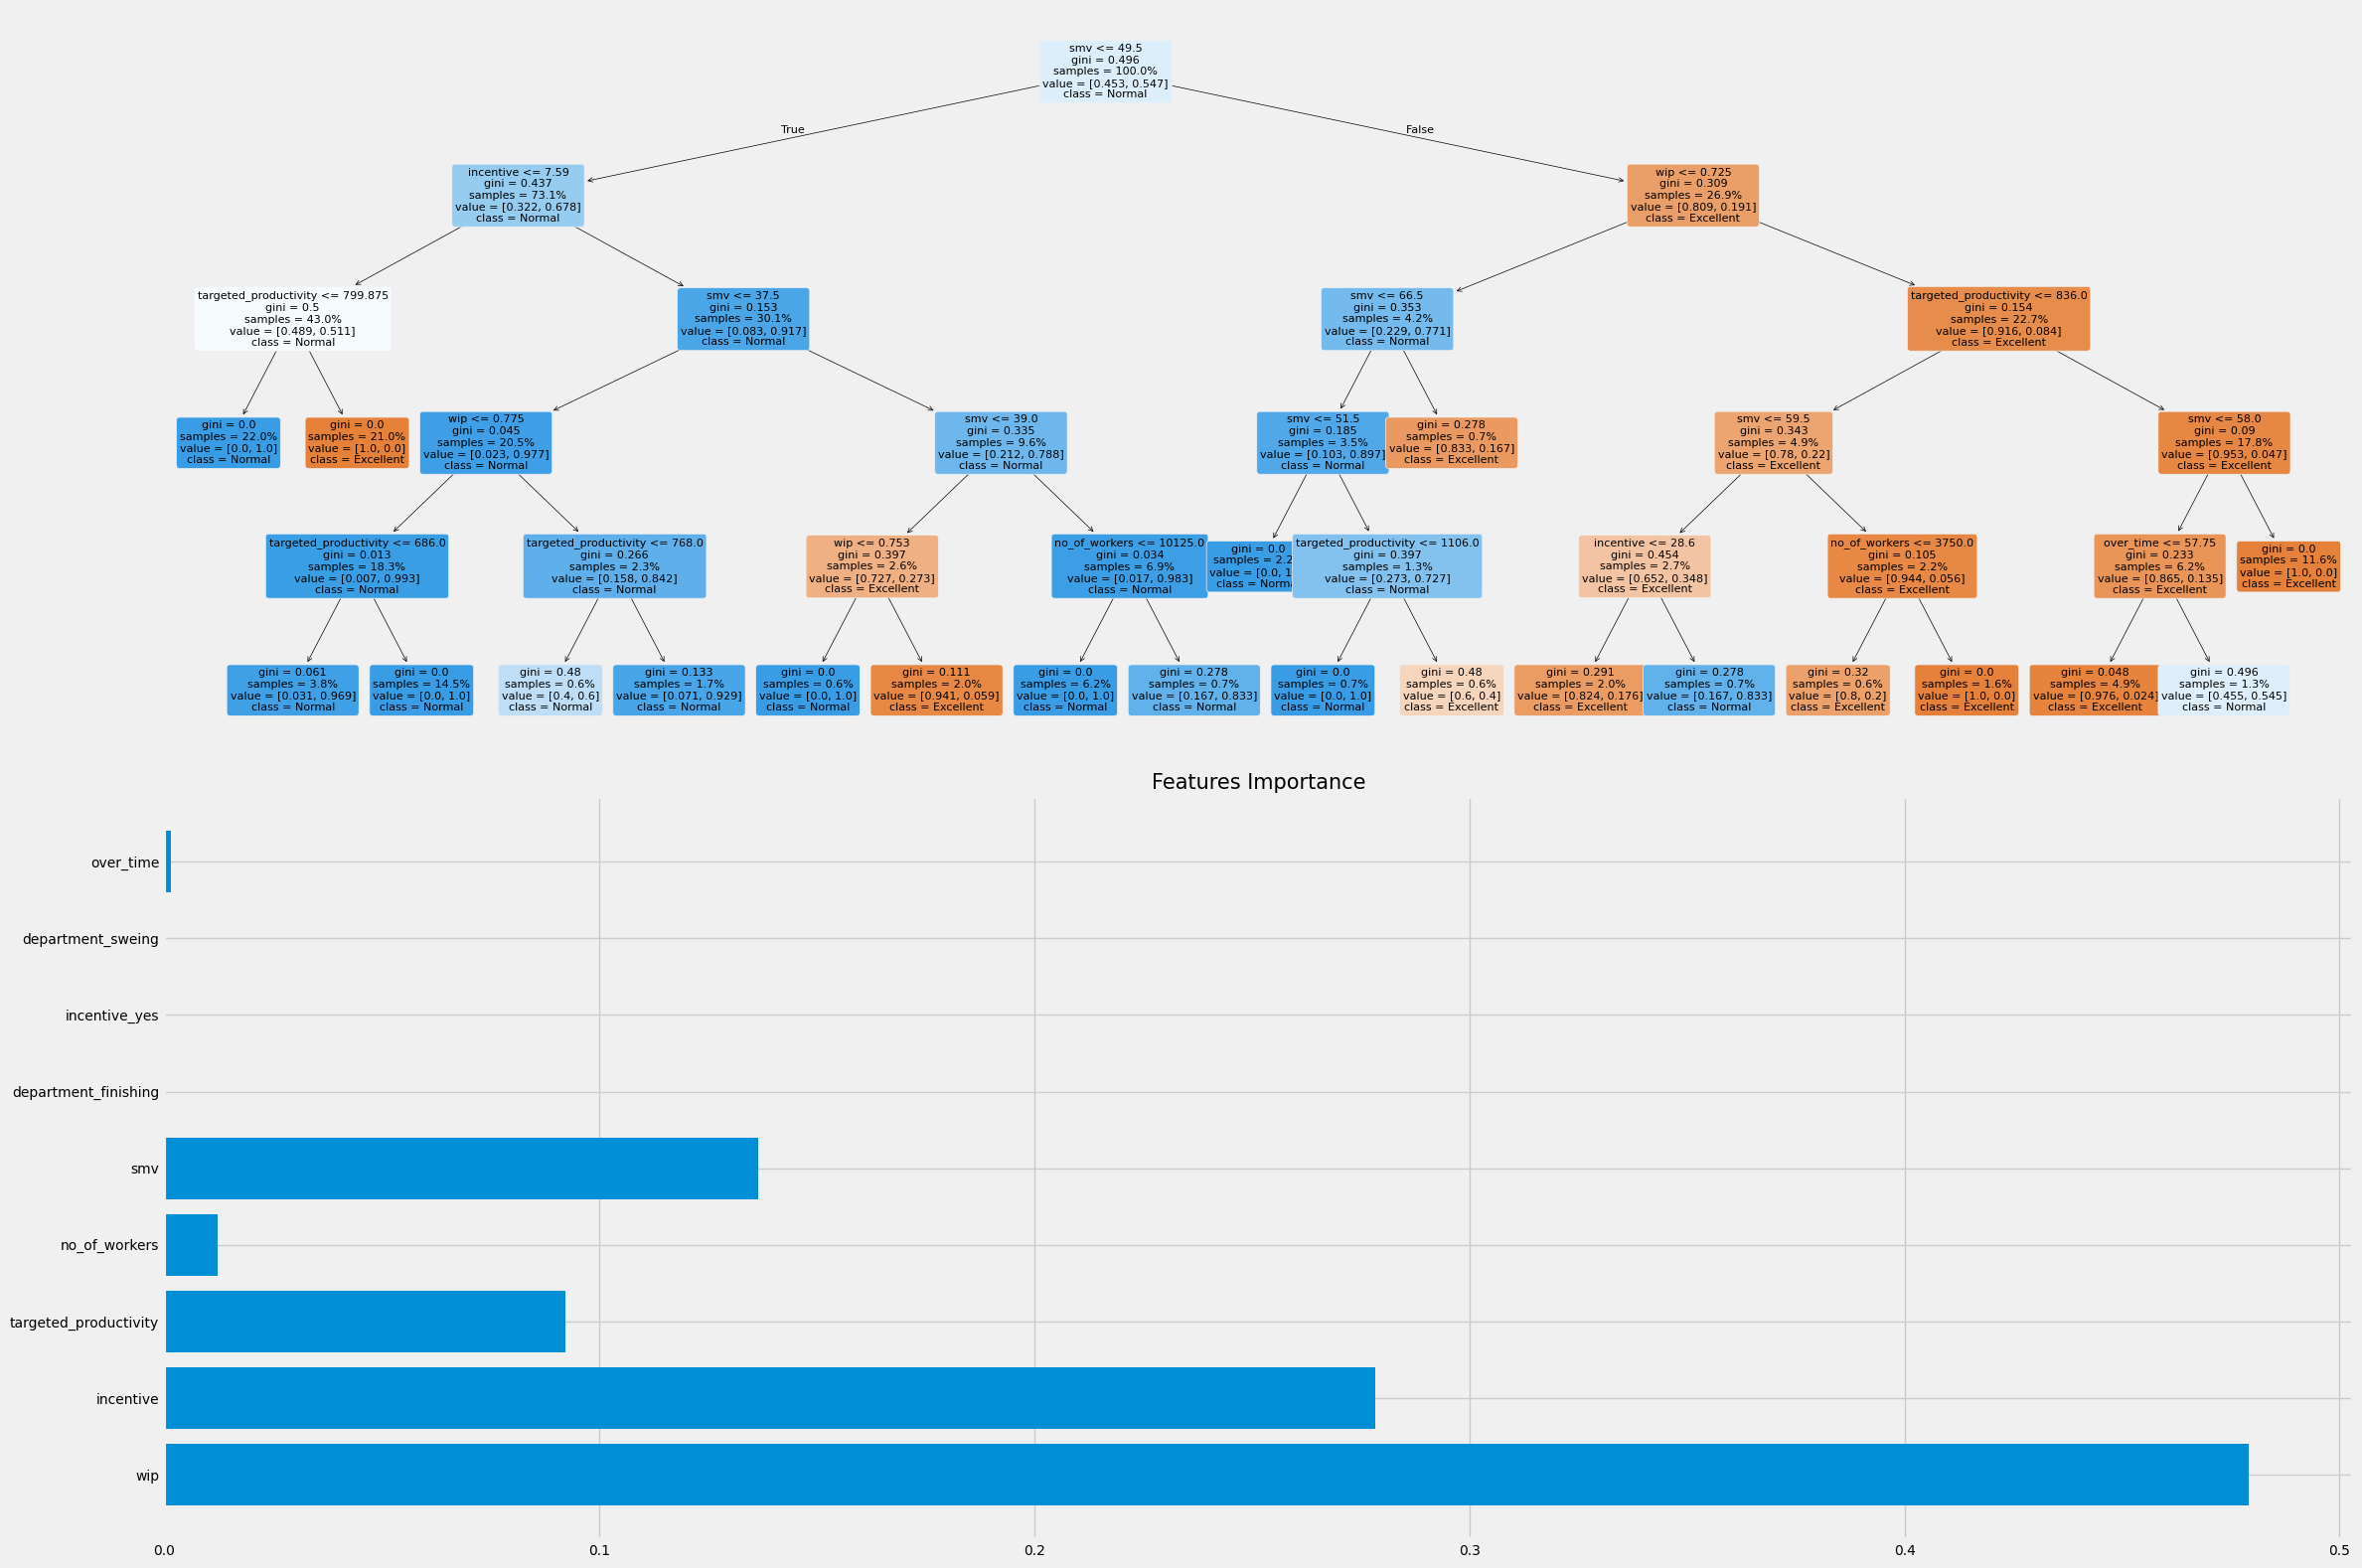

In [53]:
best_clf = gscv_clf.best_estimator_
best_clf.fit(X_train[top_feat], y_train)
fig = plt.figure(figsize=(24,16))

fig.add_subplot(2,1,1)
plot_tree(best_clf,
          feature_names=top_feat,
          class_names=best_clf.classes_,
          filled=True,
          rounded=True,
          fontsize=8,
          proportion=True)

fig.add_subplot(2,1,2)
plt.barh(best_clf.feature_names_in_, best_clf.feature_importances_)
plt.title("Features Importance", fontsize=15)
plt.tick_params(axis='both', labelsize=10)

fig.tight_layout()
plt.show()

In [54]:
y_pred = best_clf.predict(X_test[top_feat])
best_clf.score(X_test[top_feat], y_test)

0.95

&emsp;The classifier has excellent performance if it is to identify `productivity ≥ 80%`. The first split by `smv` followed by `incentive` and `wip`. `wip` is the most important feature whereas `incenetive` comes second. Since the response `productivity` is a bit subjective becauase it is affected by the set `targeted_productivity` by possibly supervisors or managers, and `wip` varies daily as well, thus the second most important feature `incentive` seems to be an accountable effect on `productivity`. Alternatively, another model with different response categories can be built to take features' inter-relationship into account.

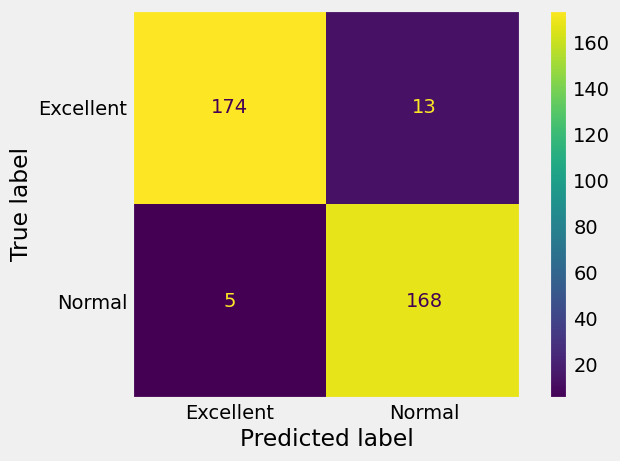

In [55]:
cm = confusion_matrix(y_test, y_pred, labels=best_clf.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=best_clf.classes_)
disp.plot()
plt.grid(False)
plt.show()

In [56]:
tpr = 174 / (174+13)
fpr = 168 / (5+168)
tpr, fpr

(0.93048128342246, 0.9710982658959537)

&emsp;The false positive rate is greater than true positive rate by about 4%. It means the model is slightly more accurate in `Normal` prediction.

In [57]:
random_clf = RandomForestClassifier(random_state=4, n_jobs=-1, warm_start=True)
params = {
    "n_estimators":[100, 200, 300],
    "max_features":[.3, .6, .9],
    "max_depth":[None, 10, 20],
    "min_samples_leaf":[1, 2, 5],
    "bootstrap":[True, False]
}
gscv = GridSearchCV(random_clf,
                    param_grid=params,
                    n_jobs=-1,
                    cv=10,
                    verbose=1)
gscv.fit(X_train[top_feat], y_train)

Fitting 10 folds for each of 162 candidates, totalling 1620 fits


GridSearchCV(cv=10,
             estimator=RandomForestClassifier(n_jobs=-1, random_state=4,
                                              warm_start=True),
             n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 10, 20],
                         'max_features': [0.3, 0.6, 0.9],
                         'min_samples_leaf': [1, 2, 5],
                         'n_estimators': [100, 200, 300]},
             verbose=1)

In [58]:
best_fc = gscv.best_estimator_
gscv.best_score_

0.9748995983935744

In [59]:
best_fc.fit(X_train[top_feat], y_train)
y_pred = best_fc.predict(X_test[top_feat])
best_fc.score(X_test[top_feat], y_test)

/Users/moswai/Documents/Mos/.venv/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:468: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(


0.9638888888888889

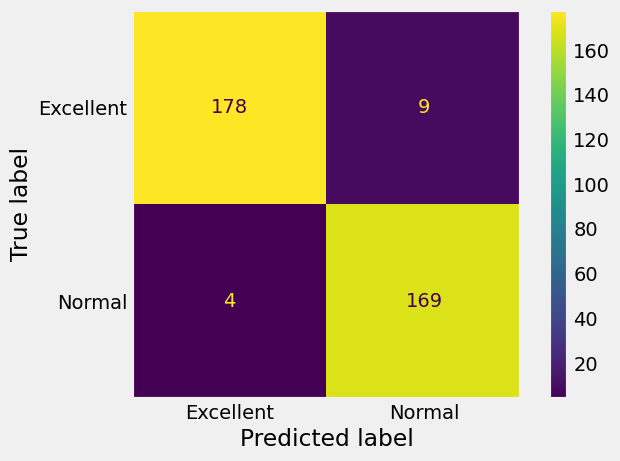

In [60]:
cm = confusion_matrix(y_test, y_pred, labels=best_fc.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=best_fc.classes_)
disp.plot()
plt.grid(False)
plt.show()

The overall accuracy and performance in terms of true and false positive rate have improved using Random Forest Classifier over Decision Tree Classifier. However, the objective of this model is only to identify `productivity` over 80%. To accurately predict the `productivity` in values, there are still room for improvement to increase $R^2$ from 0.86.